In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.cluster import KMeans

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

chunksize = 20000
chunks = pd.read_csv("../data/used_cars_data.csv", chunksize=chunksize, low_memory=False, index_col='vin')

df_list = []

for chunk in chunks:
    df_list.append(chunk)

car_df = pd.concat(df_list, axis=0)


#body_type
car_df['body_type'].replace(np.nan, 'SUV / Crossover', inplace=True)

# combined_fuel_economy
car_df['city_fuel_economy'].replace(np.nan, car_df['city_fuel_economy'].mean(), inplace=True)
car_df.loc[(car_df['fuel_type'] == 'Electric'), 'city_fuel_economy'] = 0

car_df['highway_fuel_economy'].fillna(car_df['highway_fuel_economy'].mean(), inplace=True)
car_df.loc[(car_df['fuel_type'] == 'Electric'), 'highway_fuel_economy'] = 0

car_df['combined_fuel_economy'] = (car_df['city_fuel_economy'] + car_df['highway_fuel_economy']) / 2
car_df.drop(['city_fuel_economy', 'highway_fuel_economy'], axis=1, inplace=True)
car_df['combined_fuel_economy'] = car_df['combined_fuel_economy'].round(2)

# fuel_type
car_df['fuel_type'].fillna('Gasoline', inplace=True)

#horsepower
car_df['horsepower'].fillna(car_df['horsepower'].mode()[0], inplace=True)

# major_options
car_df['major_options_count'] = car_df['major_options'].str.count(',') + 1
car_df['major_options_count'].fillna(car_df['major_options_count'].mean(), inplace=True)

# maxium_seating
car_df['maximum_seating'] = car_df['maximum_seating'].str.replace(" seats", "")
car_df['maximum_seating'].replace("--", np.nan, inplace=True)
car_df['maximum_seating'].fillna('5', inplace=True)
car_df['maximum_seating'] = pd.to_numeric(car_df['maximum_seating'], downcast='integer')

# mileage
q1 = car_df['mileage'].quantile(0.25)
q3 = car_df['mileage'].quantile(0.75)

iqr = q3 - q1

car_df = car_df[(car_df['mileage'] >= q1 - 1.5*iqr) & (car_df['mileage'] <= q3 + 1.5*iqr)]
car_df['mileage'].fillna(car_df['mileage'].mean(), inplace=True)

# price

# year

# transmission
car_df['transmission'].fillna("A", inplace=True)

# wheel_system
car_df['wheel_system'].fillna('FWD', inplace=True)

car_df_new = car_df[["body_type", "fuel_type", "horsepower", "maximum_seating", "mileage", "make_name", "price", "year", "transmission", "wheel_system", "combined_fuel_economy", "major_options_count"]]

car_df_new.head()

,body_type,fuel_type,horsepower,maximum_seating,mileage,make_name,price,year,transmission,wheel_system,combined_fuel_economy,major_options_count
vin,,,,,,,,,,,,
ZACNJABB5KPJ92081,SUV / Crossover,Gasoline,177.0,5,7.0,Jeep,23141.0,2019,A,FWD,26.08,1.000000
SALCJ2FX1LH858117,SUV / Crossover,Gasoline,246.0,7,8.0,Land Rover,46500.0,2020,A,AWD,26.08,1.000000
SALRR2RV0L2433391,SUV / Crossover,Gasoline,340.0,7,11.0,Land Rover,67430.0,2020,A,AWD,26.08,6.161012
SALCJ2FXXLH862327,SUV / Crossover,Gasoline,246.0,7,7.0,Land Rover,48880.0,2020,A,AWD,26.08,1.000000
SALYK2EX1LA261711,SUV / Crossover,Gasoline,247.0,5,12.0,Land Rover,66903.0,2020,A,AWD,26.08,8.000000


In [2]:
from sklearn.preprocessing import LabelEncoder
import pickle

#Initialize a dictionary to hold the encoders
encoders = {}

for col in car_df_new.columns:
    if car_df_new[col].dtype == 'object':
        # Create a new LabelEncoder for each column
        le = LabelEncoder()
        # Fit and transform the column data
        car_df_new[col] = le.fit_transform(car_df_new[col])
        # Store the fitted LabelEncoder in the dictionary
        encoders[col] = le

# Save each encoder to a file
for col, encoder in encoders.items():
    with open(f'../data/le_{col}.pkl', 'wb') as file:
        pickle.dump(encoder, file)

print(encoders)

car_df_new['price'] = np.log(car_df_new['price'])

car_df_new.head()

C:\Users\Emil\AppData\Local\Temp\ipykernel_17044\1010450039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df_new[col] = le.fit_transform(car_df_new[col])
C:\Users\Emil\AppData\Local\Temp\ipykernel_17044\1010450039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df_new[col] = le.fit_transform(car_df_new[col])
C:\Users\Emil\AppData\Local\Temp\ipykernel_17044\1010450039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

{'body_type': LabelEncoder(), 'fuel_type': LabelEncoder(), 'make_name': LabelEncoder(), 'transmission': LabelEncoder(), 'wheel_system': LabelEncoder()}


C:\Users\Emil\AppData\Local\Temp\ipykernel_17044\1010450039.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df_new[col] = le.fit_transform(car_df_new[col])
C:\Users\Emil\AppData\Local\Temp\ipykernel_17044\1010450039.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df_new['price'] = np.log(car_df_new['price'])


,body_type,fuel_type,horsepower,maximum_seating,mileage,make_name,price,year,transmission,wheel_system,combined_fuel_economy,major_options_count
vin,,,,,,,,,,,,
ZACNJABB5KPJ92081,5,5,177.0,5,7.0,43,10.049361,2019,0,3,26.08,1.000000
SALCJ2FX1LH858117,5,5,246.0,7,8.0,50,10.747208,2020,0,2,26.08,1.000000
SALRR2RV0L2433391,5,5,340.0,7,11.0,50,11.118845,2020,0,2,26.08,6.161012
SALCJ2FXXLH862327,5,5,246.0,7,7.0,50,10.797124,2020,0,2,26.08,1.000000
SALYK2EX1LA261711,5,5,247.0,5,12.0,50,11.110999,2020,0,2,26.08,8.000000


R2 Model score is:  0.92
0.020661856029440137
0.1051088068447563
3.698576955458476
0.920774983503112


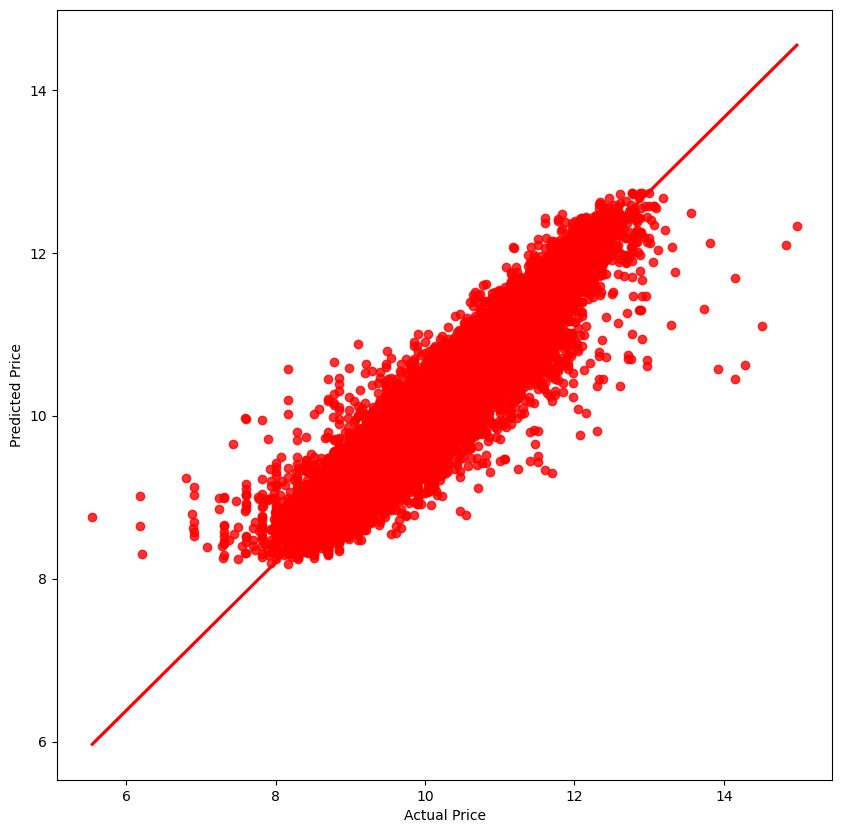

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
from sklearn import preprocessing
from sklearn.ensemble import  HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import pickle
import os

modelHGB = HistGradientBoostingRegressor()

#Splitting the data
X = car_df_new.drop("price", axis=1)
y = car_df_new["price"]


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =42)
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Now, save the fitted scaler for later use
with open('../data/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Only transform the test data
X_test_scaled = scaler.transform(X_test)

modelHGB.fit(X_train_scaled, y_train)

relative_path = "../data/model.pkl"
directory = os.path.dirname(relative_path)
os.makedirs(directory, exist_ok=True)
# Save the model
with open(relative_path, 'wb') as file:
    pickle.dump(modelHGB, file)

y_pred = modelHGB.predict(X_test_scaled)

print("R2 Model score is: ", round(r2_score(y_test, y_pred),2))
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(max_error(y_test, y_pred))
print(r2_score(y_test, y_pred)) 

result = pd.DataFrame({'Actual Price':y_test,
                     "Predicted Price":y_pred})
df_car_price_bck = car_df_new.copy()
Result = df_car_price_bck.merge(result, left_index=True,right_index=True)
Result

plt.figure(figsize = (10,10))
sns.regplot(x = 'Actual Price', y='Predicted Price', data=result, color='red')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

R2 Model score is:  0.89
0.027601215599670242
0.11926192842599805
4.051238555840223
0.8941669732814759


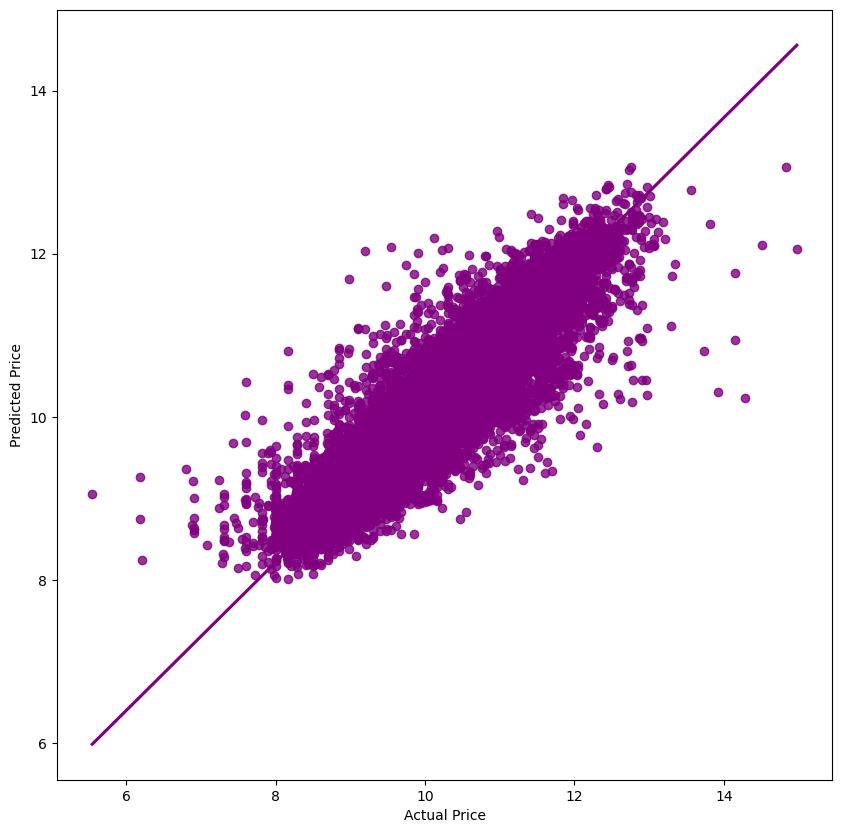

In [4]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create an instance of MLPRegressor
modelMLP = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=42)  # You can adjust parameters as needed

# Splitting the data
X = car_df_new.drop("price", axis=1)
y = car_df_new["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Save the fitted scaler for later use
with open('../data/scaler_MLP.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Only transform the test data
X_test_scaled = scaler.transform(X_test)

# Fit the MLPRegressor model
modelMLP.fit(X_train_scaled, y_train)

# Save the model using pickle
relative_path_MLP = "../data/model_MLP.pkl"
directory_MLP = os.path.dirname(relative_path_MLP)
os.makedirs(directory_MLP, exist_ok=True)

with open(relative_path_MLP, 'wb') as file:
    pickle.dump(modelMLP, file)

# Make predictions
y_pred_MLP = modelMLP.predict(X_test_scaled)

# Evaluate the model
print("R2 Model score is: ", round(r2_score(y_test, y_pred_MLP), 2))
print(mean_squared_error(y_test, y_pred_MLP))
print(mean_absolute_error(y_test, y_pred_MLP))
print(max_error(y_test, y_pred_MLP))
print(r2_score(y_test, y_pred_MLP))

# Display results
result_MLP = pd.DataFrame({'Actual Price': y_test, "Predicted Price": y_pred_MLP})
df_car_price_bck_MLP = car_df_new.copy()
Result_MLP = df_car_price_bck_MLP.merge(result_MLP, left_index=True, right_index=True)

# Visualize the results
plt.figure(figsize=(10, 10))
sns.regplot(x='Actual Price', y='Predicted Price', data=result_MLP, color='purple')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()



R2 Model score is:  0.7
0.07915806901716545
0.20806501015874987
5.126166723465005
0.6964793813870814


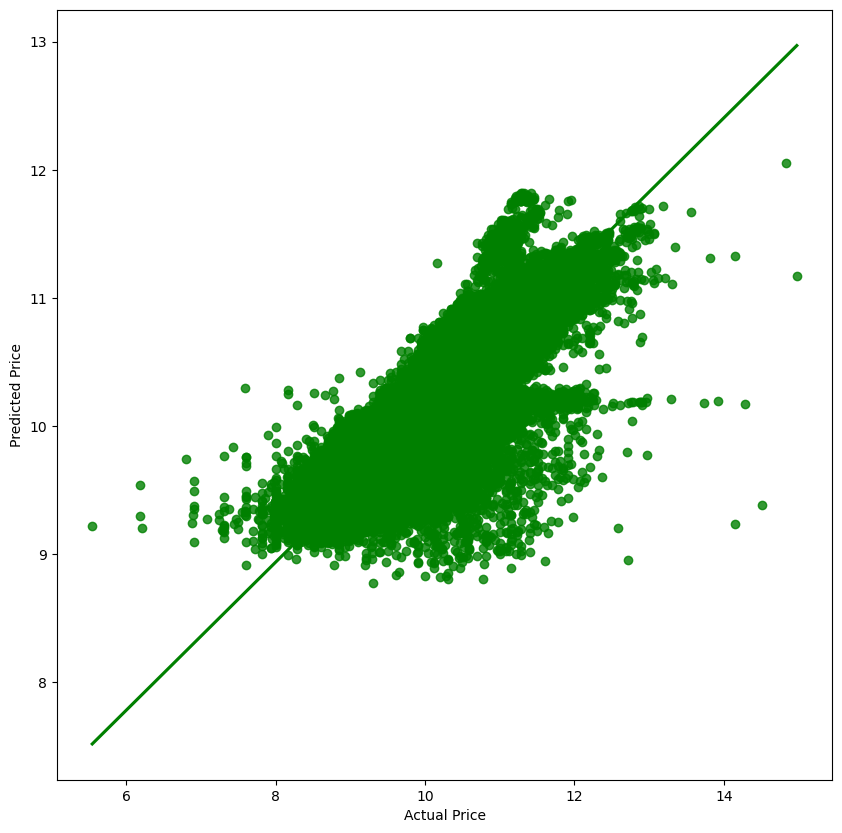

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create an instance of ElasticNet
modelEN = ElasticNet(alpha=0.1, l1_ratio=0.5)  # You can adjust alpha and l1_ratio as needed

# Splitting the data
X = car_df_new.drop("price", axis=1)
y = car_df_new["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Save the fitted scaler for later use
with open('../data/scaler_EN.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Only transform the test data
X_test_scaled = scaler.transform(X_test)

# Fit the ElasticNet model
modelEN.fit(X_train_scaled, y_train)

# Save the model using pickle
relative_path_EN = "../data/model_EN.pkl"
directory_EN = os.path.dirname(relative_path_EN)
os.makedirs(directory_EN, exist_ok=True)

with open(relative_path_EN, 'wb') as file:
    pickle.dump(modelEN, file)

# Make predictions
y_pred_EN = modelEN.predict(X_test_scaled)

# Evaluate the model
print("R2 Model score is: ", round(r2_score(y_test, y_pred_EN), 2))
print(mean_squared_error(y_test, y_pred_EN))
print(mean_absolute_error(y_test, y_pred_EN))
print(max_error(y_test, y_pred_EN))
print(r2_score(y_test, y_pred_EN))

# Display results
result_EN = pd.DataFrame({'Actual Price': y_test, "Predicted Price": y_pred_EN})
df_car_price_bck_EN = car_df_new.copy()
Result_EN = df_car_price_bck_EN.merge(result_EN, left_index=True, right_index=True)

# Visualize the results
plt.figure(figsize=(10, 10))
sns.regplot(x='Actual Price', y='Predicted Price', data=result_EN, color='green')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()


R2 Model score is:  0.94
0.015713662010778187
0.08568491705595639
4.418369588165563
0.9397481460399006


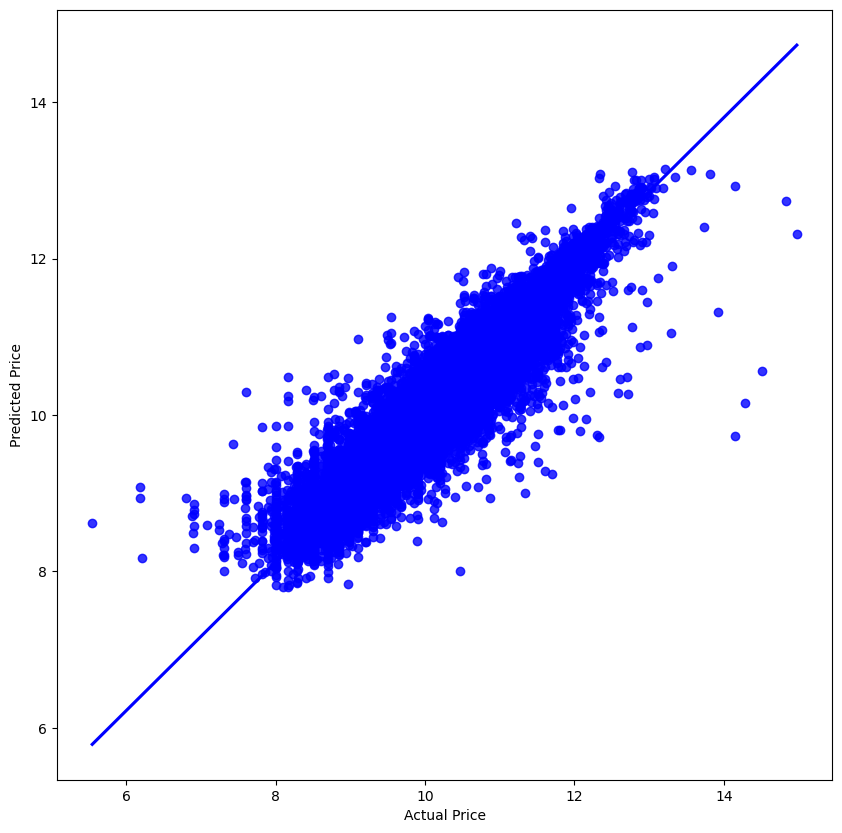

In [6]:
from sklearn.neighbors import KNeighborsRegressor

# Create an instance of K-nearest Neighbors (KNN) Regressor
modelKNN = KNeighborsRegressor(n_neighbors=5)

# Splitting the data
X = car_df_new.drop("price", axis=1)
y = car_df_new["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Save the fitted scaler for later use
with open('../data/scaler_KNN.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Only transform the test data
X_test_scaled = scaler.transform(X_test)

# Fit the K-nearest Neighbors (KNN) Regressor model
modelKNN.fit(X_train_scaled, y_train)

# Save the model using pickle
relative_path_KNN = "../data/model_KNN.pkl"
directory_KNN = os.path.dirname(relative_path_KNN)
os.makedirs(directory_KNN, exist_ok=True)

with open(relative_path_KNN, 'wb') as file:
    pickle.dump(modelKNN, file)

# Make predictions
y_pred_KNN = modelKNN.predict(X_test_scaled)

# Evaluate the model
print("R2 Model score is: ", round(r2_score(y_test, y_pred_KNN), 2))
print(mean_squared_error(y_test, y_pred_KNN))
print(mean_absolute_error(y_test, y_pred_KNN))
print(max_error(y_test, y_pred_KNN))
print(r2_score(y_test, y_pred_KNN))

# Display results
result_KNN = pd.DataFrame({'Actual Price': y_test, "Predicted Price": y_pred_KNN})
df_car_price_bck_KNN = car_df_new.copy()
Result_KNN = df_car_price_bck_KNN.merge(result_KNN, left_index=True, right_index=True)

# Visualize the results
plt.figure(figsize=(10, 10))
sns.regplot(x='Actual Price', y='Predicted Price', data=result_KNN, color='blue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

# Yhteenveto tuloksista

### HistGradientBoostingRegressor
* R2 Model score: 0.92
* Keskimääräinen neliövirhe (MSE): 0.0207
* Keskimääräinen ehdollinen virhe (MAE): 0.1051
* Selitysaste: 0.9208

### MLPRegressor:
* R2 Model score: 0.89
* Keskimääräinen neliövirhe (MSE): 0.0276
* Keskimääräinen ehdollinen virhe (MAE): 0.1193
* Selitysaste: 0.8942

### ElasticNet:
* R2 Model score: 0.7
* Keskimääräinen neliövirhe (MSE): 0.0792
* Keskimääräinen ehdollinen virhe (MAE): 0.2081
* Selitysaste: 0.6965

### KNeighborsRegressor:
* R2 Model score: 0.94
* Keskimääräinen neliövirhe (MSE): 0.0157
* Keskimääräinen ehdollinen virhe (MAE): 0.0857
* Selitysaste: 0.9397

## Tulosten vertailua
Kaikki mallit vaikuttavat suoriutuvan hyvin, mutta KNeighborsRegressorilla on korkein R2-pistemäärä (0.94), mikä osoittaa erittäin hyvää sovitusta dataan.  
Tuloksen parantaminen tässä vaiheessa vaatisi todennäköisesti lisäponnisteluja piirteiden parantamiseksi. Tämän voisi toteuttaa tarkastelemalla tarkemmin olemassa olevia piirteitä ja  
niiden mahdollisia muokkauksia. Voisimme myös yrittää etsiä uusia ennustetta parantavien lisäpiirteitä mallin suorituskyvyn viimeistelemiseksi.
Gradient Boosting -menetelmän (HistGradientBoostingRegressor) ja MLPRegressorin välillä on  
pieni suorituskykyero, mutta molemmat ovat silti varsin tehokkaita.
ElasticNet suoriutuu hieman heikommin, kuten osoittaa alhaisempi R2-pistemäärä ja korkeammat virhearvot.  
ElasticNet saattaa olla liian monimutkainen malli tähän ns. yksinkertaiseen ongelmaan, koska  
KNeighborsRegressori malli on yksi yksinkertaisimmista malleista ja se pärjäsi parhaiten.  
KNeighborsRegressor toiminta perustuu siihen että se tekee ennusteita uusille datapisteille ottamalla huomioon niiden lähimpien naapureiden arvot.  
Tämä soveltuu hyvin tilanteisiin, joissa on havaittavissa yksinkertaisempia riippuvuuksia datassa.


